## Analysis of recommenders

In [1]:
# Base
from Recommenders.Base.TopPop import TopPop

# CF
from Recommenders.CF.KNN.ItemKNNCF import ItemKNNCF
from Recommenders.CF.KNN.UserKNNCF import UserKNNCF
from Recommenders.CF.KNN.RP3beta import RP3beta
from Recommenders.CF.KNN.P3alpha import P3alpha
from Recommenders.CF.KNN.EASE_R import EASE_R
from Recommenders.CF.MatrixFactorization.PureSVD import PureSVD, PureSVDItem, ScaledPureSVD
from Recommenders.CF.KNN.SLIMElasticNet import SLIMElasticNet, MultiThreadSLIM_SLIMElasticNet
from Recommenders.CF.KNN.SLIM_BPR import SLIM_BPR
from Recommenders.CF.MatrixFactorization.IALS import IALS
from Recommenders.CF.MatrixFactorization.NMF import NMF
from Recommenders.CF.LightFM import LightFM
from Recommenders.CF.MultVAE import MultVAE
from Recommenders.CF.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython,\
    MatrixFactorization_FunkSVD_Cython, MatrixFactorization_AsySVD_Cython

# CB
from Recommenders.CB.KNN.ItemKNNCBF import ItemKNNCBF

# Hybrid 
from Recommenders.Hybrid.ItemKNN_CFCBF_Hybrid import ItemKNN_CFCBF_Hybrid
from Recommenders.Hybrid.Hybrid1 import Hybrid1
from Recommenders.Hybrid.Hybrid2 import Hybrid2
from Recommenders.Hybrid.Hybrid3 import Hybrid3

C:\Users\Martim\AppData\Local\Programs\Python\Python39\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
import os
from Utils.Dataset import Dataset

dataset = Dataset(path='./Data', validation_percentage=0, test_percentage=0.2, seed=1234)
stacked_URM, _ = dataset.stack_URM_ICM(dataset.URM_train, dataset.ICM)
output_folder_path = os.path.join('Recommenders', 'saved_models', 'test'+os.sep)

In [3]:
EASE_R_test = EASE_R(stacked_URM)
EASE_R_test.load_model(output_folder_path)

ItemKNN_CFCBF_Hybrid_test = ItemKNN_CFCBF_Hybrid(stacked_URM, dataset.ICM)
ItemKNN_CFCBF_Hybrid_test.load_model(output_folder_path)

ItemKNNCF_test = ItemKNNCF(stacked_URM)
ItemKNNCF_test.load_model(output_folder_path)

PureSVD_test = PureSVD(stacked_URM)
PureSVD_test.load_model(output_folder_path)

PureSVDItem_test = PureSVDItem(stacked_URM)
PureSVDItem_test.load_model(output_folder_path)

RP3beta_test = RP3beta(stacked_URM)
RP3beta_test.load_model(output_folder_path)

SLIM_BPR_test = SLIM_BPR(stacked_URM)
SLIM_BPR_test.load_model(output_folder_path)

SLIMElasticNet_test = SLIMElasticNet(stacked_URM)
SLIMElasticNet_test.load_model(output_folder_path)

UserKNNCF_test = UserKNNCF(stacked_URM)
UserKNNCF_test.load_model(output_folder_path)

EASE_R: Loading model from file Recommenders\saved_models\test\EASE_R
EASE_R: Loading complete
ItemKNN_CFCBF_Hybrid: Loading model from file Recommenders\saved_models\test\ItemKNN_CFCBF_Hybrid
ItemKNN_CFCBF_Hybrid: Loading complete
ItemKNNCF: Loading model from file Recommenders\saved_models\test\ItemKNNCF
ItemKNNCF: Loading complete
PureSVD: Loading model from file Recommenders\saved_models\test\PureSVD
PureSVD: Loading complete
PureSVDItem: Loading model from file Recommenders\saved_models\test\PureSVDItem
PureSVDItem: Loading complete
RP3beta: Loading model from file Recommenders\saved_models\test\RP3beta
RP3beta: Loading complete
SLIM_BPR: Loading model from file Recommenders\saved_models\test\SLIM_BPR
SLIM_BPR: Loading complete
SLIMElasticNet: Loading model from file Recommenders\saved_models\test\SLIMElasticNet
SLIMElasticNet: Loading complete
UserKNNCF: Loading model from file Recommenders\saved_models\test\UserKNNCF
UserKNNCF: Loading complete


In [4]:
import numpy as np 
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(dataset.URM_train).indptr)
profile_length, profile_length.shape

(array([141, 499, 111, ..., 214, 150, 257], dtype=int32), (13650,))

In [5]:
num_split = 6

In [6]:
block_size = int(len(profile_length)*(1/num_split))
block_size

2275

In [7]:
sorted_users = np.argsort(profile_length)
sorted_users

array([ 1648, 10647, 11672, ...,  1141,  8526,   317], dtype=int64)

In [8]:
for group_id in range(0, num_split):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 2275, average p.len 75.74, median 80.0, min 5, max 127
Group 1, #users in group 2275, average p.len 164.75, median 165.0, min 128, max 199
Group 2, #users in group 2275, average p.len 235.81, median 236.0, min 199, max 272
Group 3, #users in group 2275, average p.len 311.34, median 311.0, min 272, max 354
Group 4, #users in group 2275, average p.len 412.18, median 409.0, min 354, max 485
Group 5, #users in group 2275, average p.len 658.88, median 606.0, min 485, max 1733


In [9]:
from Utils.import_recommenders import *

MAP_recommender_per_group = {}

recommenders = {
    'ItemKNNCF': ItemKNNCF_test,
    'UserKNNCF': UserKNNCF_test,
    'RP3beta': RP3beta_test,
    'EASE_R': EASE_R_test,
    'SLIMElasticNet': SLIMElasticNet_test,
    'ItemKNN_CFCBF_Hybrid': ItemKNN_CFCBF_Hybrid_test,
    }

recommender_object_dict = {}

for label, recommender_object in recommenders.items():
    recommender_object_dict[label] = recommender_object

In [ ]:
from Utils.Evaluator import EvaluatorHoldout

for group_id in range(0, len(recommenders)):
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    users_in_group = sorted_users[start_pos:end_pos]
    users_in_group_p_len = profile_length[users_in_group]
    
    print('Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}'.format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(dataset.URM_test, cutoff_list=[10], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[10]['MAP'])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[10]['MAP']]
        

In [11]:
for label, recommender in recommender_object_dict.items():
  result_df, _ = evaluator_test.evaluateRecommender(recommender)
  if label in MAP_recommender_per_group:
      MAP_recommender_per_group[label].append(result_df.loc[10]['MAP'])
  else:
      MAP_recommender_per_group[label] = [result_df.loc[10]['MAP']]

EvaluatorHoldout: Processed 2275 (100.0%) in 1.01 sec. Users per second: 2253
EvaluatorHoldout: Processed 2275 (100.0%) in 4.39 sec. Users per second: 519
EvaluatorHoldout: Processed 2275 (100.0%) in 1.35 sec. Users per second: 1689
EvaluatorHoldout: Processed 2275 (100.0%) in 8.23 sec. Users per second: 276
EvaluatorHoldout: Processed 2275 (100.0%) in 0.72 sec. Users per second: 3142
EvaluatorHoldout: Processed 2275 (100.0%) in 7.66 sec. Users per second: 297
EvaluatorHoldout: Processed 2275 (100.0%) in 2.26 sec. Users per second: 1005
EvaluatorHoldout: Processed 2275 (100.0%) in 3.25 sec. Users per second: 700
EvaluatorHoldout: Processed 2275 (100.0%) in 1.38 sec. Users per second: 1645


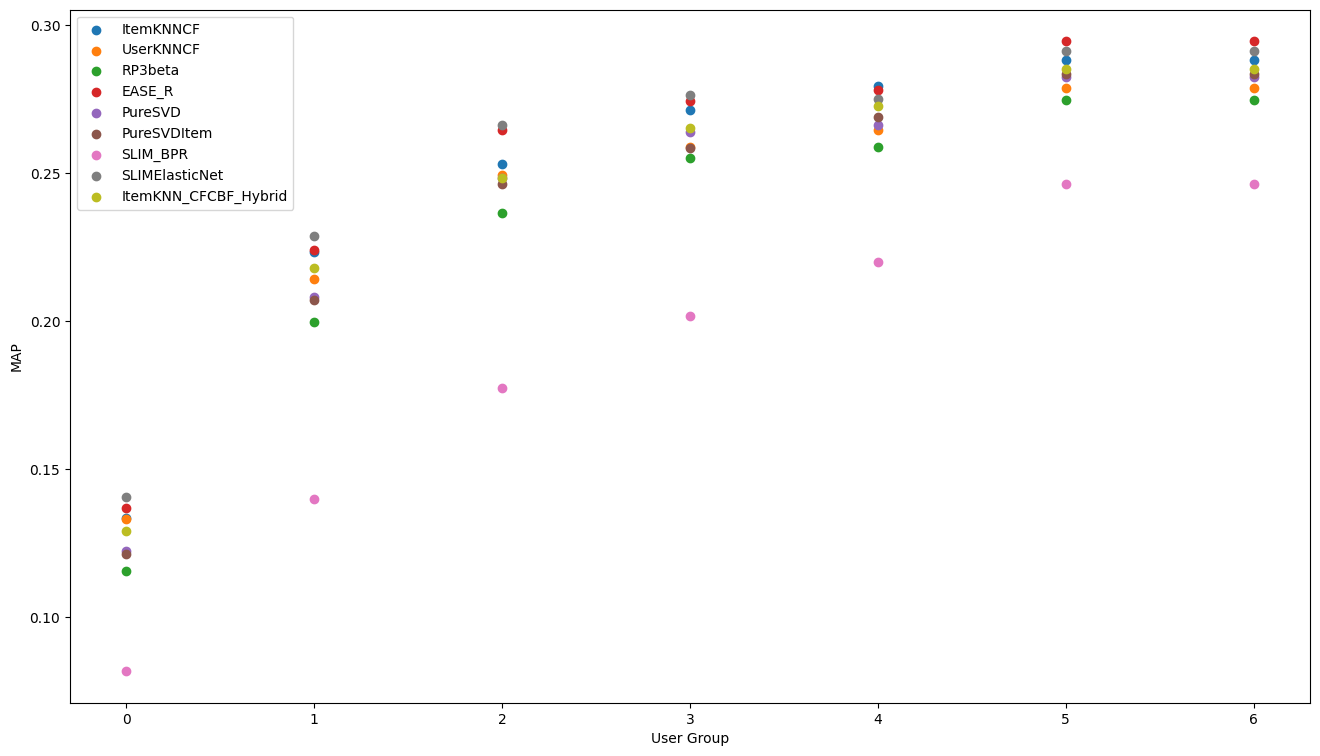

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)

plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

In [ ]:
for label, recommender in recommender_object_dict.items():
    print(f'Recommender: {label}')
    results = MAP_recommender_per_group[label]
    
    for idx, res in enumerate(results): 
        print(f'\tGroup {idx}: {res}')